In [ ]:
!pip install basemap
!pip install basemap-data-hires

!pip install ipympl
!pip install nodejs-bin
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib
!pip install graphviz
!pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.0
    Uninstalling pyproj-3.7.0:
      Successfully uninstalled pyproj-3.7.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 8.0 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 8.9 MB/s eta 0:00:00
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir] [--paths] [--json]
               [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: bundlerextension console dejavu execute kernel kernelspe

In [ ]:
import shapely.geometry
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from datetime import datetime
import time
import copy

import math
import IPython
import pickle
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install import_ipynb
import import_ipynb

%cd '/content/drive/MyDrive/Colab Notebooks/PathRecommendation/'

/content/drive/MyDrive/Colab Notebooks/PathRecommendation


# AIS 데이터 전처리

* 사용한 ais 데이터 - 2020.02.04일자

* 생성 파일 - ais, ais_ts_list, ais_dict

* ais = 선박 데이터(MMSI, 일자, 시간, 위도, 경도, SOG, COG, Heading)

* ais_ts_list = 타임 슬라이싱 리스트, 0시부터 24시, 30분 단위 슬라이싱

* ais_dict = 키는 mmsi 아이디, 밸류는 해당 선박의 ais데이터

In [ ]:
#대상 범위:(33, 125.5) ~ (35, 127.5)
base_lat = [33, 35]
base_lon = [125.5, 127.5]

In [ ]:
#구글 드라이브에 ais파일 존재여부 확인 -> 없을 시 생성

DATA_DIR = "./data/"
DATA_NAME = 'Dynamic_20200204.csv'
skiprow_count = 3

f = open(DATA_DIR+DATA_NAME, 'r', encoding='cp949')
for i in range(0, skiprow_count):
    line = f.readline()
    if not line: break
    print(line)
f.close()

if os.path.isfile('./files/ais_0204.pkl'): #피클 파일 존재
    print("ais 이미 존재")

    with open('./files/ais_0204.pkl', 'rb') as f:
        ais = pickle.load(f)

    print('Data len in Range(After drop):' + str(len(ais)))

else:
    print("ais파일 없음, 생성 및 저장 시작") #피클 파일 없음
    chunk = pd.read_csv(DATA_DIR+DATA_NAME,
                      encoding='cp949', sep='\s+|,', engine='python',
                      skiprows=range(0, skiprow_count),
                      names=['MMSI','일자', '시간', '위도','경도', 'SOG', 'COG', 'Heading'], chunksize = 1000000)
    ais = pd.concat(chunk)

    print('Data len in AIS:' + str(len(ais)))
    ais.drop(ais[(ais['위도'] < base_lat[0]) | (ais['위도'] > base_lat[1]) | (ais['경도'] < base_lon[0]) | (ais['경도'] > base_lon[1])].index, inplace=True)
    print('Data len in Range:' + str(len(ais)))

    with open('./files/ais_0204.pkl', 'wb') as f:
        pickle.dump(ais, f)

조회 기간 : 2020-02-04 00:00:00 ~ 2020-02-04 23:59:59

조회선박 척수 : 7850

MMSI,일시,위도,경도,SOG,COG,Heading

ais파일 없음, 생성 및 저장 시작
Data len in AIS:20653646
Data len in Range:4999445


In [ ]:
ais.head()

,MMSI,일자,시간,위도,경도,SOG,COG,Heading
1,rjFyyVyimurB7BM2WdKWWQ==,2020-02-04,00:00:01,33.952555,126.817868,3.0,96.4,90
2,rjFyyVyimurB7BM2WdKWWQ==,2020-02-04,00:00:12,33.952547,126.818030,2.9,92.6,89
3,rjFyyVyimurB7BM2WdKWWQ==,2020-02-04,00:00:22,33.952538,126.818197,2.8,89.8,88
4,rjFyyVyimurB7BM2WdKWWQ==,2020-02-04,00:00:33,33.952530,126.818360,2.9,89.7,88
5,rjFyyVyimurB7BM2WdKWWQ==,2020-02-04,00:00:42,33.952528,126.818527,2.8,95.1,88


In [ ]:
#구글 드라이브에 ais_ts_list 파일 존재여부 확인 -> 없을 시 생성

if os.path.isfile('./files/ais_ts_list.pkl'):
    print("ais_ts_list 존재함")

else:
    print("ais_ts_list 없음, 생성 및 저장 시작")
    time_range = pd.date_range('00:00:00', '23:59:59', freq='30min').time

    # AIS time slicing list (30min)
    ais_ts_list = []
    ais['시간'] = pd.to_datetime(ais['시간']).dt.time

    for i in range(len(time_range) - 1):
        start_time = time_range[i]
        end_time = time_range[i + 1]
        df = ais[(ais['시간'] >= start_time) & (ais['시간'] < end_time)]
        ais_ts_list.append(df)

    # 마지막 시간 범위
    start_time = time_range[-1]
    df = ais[ais['시간'] >= start_time]
    ais_ts_list.append(df)

    # pickle 파일로 저장
    with open('./files/ais_ts_list.pkl', 'wb') as f:
        pickle.dump(ais_ts_list, f)

#존재하는 pickle파일 read
with open('./files/ais_ts_list.pkl', 'rb') as f:
    ais_ts_list = pd.read_pickle(f)

ais_ts_list 없음, 생성 및 저장 시작


<ipython-input-8-8e886931855e>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ais['시간'] = pd.to_datetime(ais['시간']).dt.time


In [ ]:
#구글 드라이브에 ais_dict 파일 존재여부 확인 -> 없을 시 생성
mmsis = list(set(ais["MMSI"].tolist()))

if os.path.isfile('./files/ais_dict.pkl'):
    print("ais_dict 존재함")

else:
    print("ais_dict 없음, 생성 및 저장 시작")
    ais_dict = {}
    progress = []
    for i in range(0, len(mmsis)):
        per = int((i/len(mmsis))*100)
        if(per%5 == 0 and per not in progress):
            progress.append(per)
            print('Progress rate: %d/%d'%(per, 100))

        ais_dict[mmsis[i]] = ais[ais['MMSI'] == mmsis[i]]
    print('Progress rate: %d/%d'%(100, 100))

    # dictionary형태인 ais_dict를 pickle 파일로 저장
    with open('./files/ais_dict.pkl', 'wb') as f:
        pickle.dump(ais_dict, f)


#존재하는 pickle파일 read
with open('./files/ais_dict.pkl', 'rb') as f:
    ais_dict = pd.read_pickle(f)

ais_dict 없음, 생성 및 저장 시작
Progress rate: 0/100
Progress rate: 5/100
Progress rate: 10/100
Progress rate: 15/100
Progress rate: 20/100
Progress rate: 25/100
Progress rate: 30/100
Progress rate: 35/100
Progress rate: 40/100
Progress rate: 45/100
Progress rate: 50/100
Progress rate: 55/100
Progress rate: 60/100
Progress rate: 65/100
Progress rate: 70/100
Progress rate: 75/100
Progress rate: 80/100
Progress rate: 85/100
Progress rate: 90/100
Progress rate: 95/100
Progress rate: 100/100


# ais 데이터 시각화 및 실제 목포-제주 경로 확인

In [ ]:
#20200204 AIS데이터 시각화
def draw_basemap_grid(lats, lons, m, color):
    x, y = m(lons, lats)
    xy = zip(x, y)
    poly = Polygon(list(xy), facecolor=color, edgecolor='black', lw=0.7, alpha=0.4)
    plt.gca().add_patch(poly)
    return poly

print('Draw Basemap')
f = plt.figure(figsize=[20,20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0],
            urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
            resolution='h', projection='merc',)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

with open('./files/grid_lon_3km.pkl', 'rb') as f:
    grid_lon = pd.read_pickle(f)
with open('./files/grid_lat_3km.pkl', 'rb') as f:
    grid_lat = pd.read_pickle(f)

print('Draw Gridmap')
for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        p = draw_basemap_grid(lats, lons, m, "none")

print('Draw AIS data')
ais_lons = ais.경도.tolist()
ais_lats = ais.위도.tolist()

ais_lons, ais_lats = m(ais_lons, ais_lats)
plt.plot(ais_lons, ais_lats, 'o', c='royalblue', alpha=0.1, markersize=0.2)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#실제 경로 확인용 MMSI 선정
출발지와 목적지가 명확한 mmsi 선박 찾기


Draw Gridmap


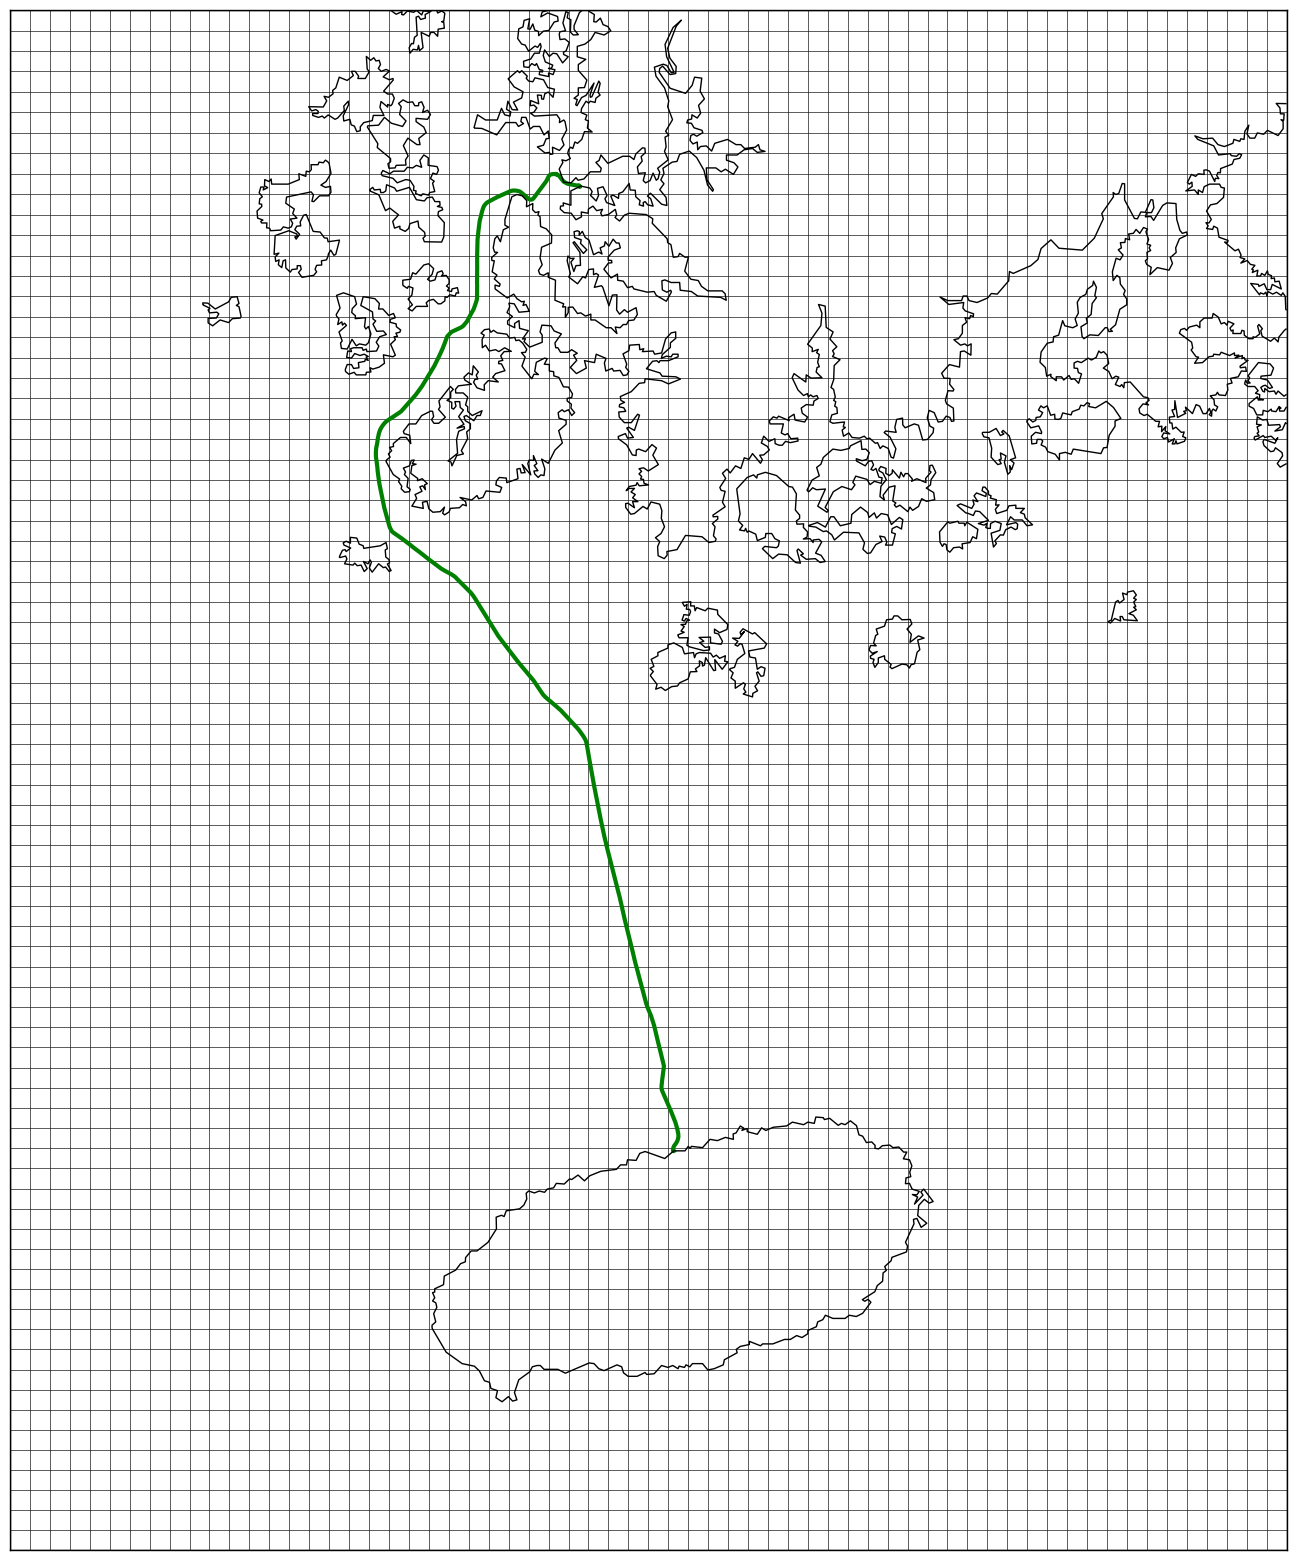

In [ ]:
mmsi_index = mmsis.index('rsK/TL2snFF0wlYXzPTWUQ==') #시각화 하려고 하는 mmsi(20번째)

pais = ais_dict[mmsis[mmsi_index]]
pais = pais[:(len(pais)//2)]

real_path_lats = copy.deepcopy(pais.위도.tolist())
real_path_lons = copy.deepcopy(pais.경도.tolist())

f = plt.figure(figsize=[20,20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0],
        urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
        resolution='h', projection='merc',)

x, y = m(real_path_lons, real_path_lats)
m.plot(x, y, linewidth=3, color='g')

print('Draw Gridmap')
for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        p = draw_basemap_grid(lats, lons, m, "none")

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()
plt.show()

In [ ]:
#실제 경로 저장
with open('./files/real_path_lats.pkl', 'wb') as f:
        pickle.dump(real_path_lats, f)
with open('./files/real_path_lons.pkl', 'wb') as f:
        pickle.dump(real_path_lons, f)

# 그리드맵에 데이터 채우기

* grid_map[key] = [베이스맵 객체, [], ‘’, N, E, S, W, 유클리디안 거리, 영역, 수온, 최대파고, 유의파고, 평균파고, 파주기]

* 지금 데이터를 넣고자하는 그리드 크기에 맞게 아래 pkl파일 불러오기 코드의 주석을 제거하여 사용


In [ ]:
import ScoringTraffic as scoreT
import ScoringWeather as scoreW
import ScoringDistance as scoreD

In [ ]:
destination = [33.528324, 126.544117]

In [ ]:
#3km그리드
with open('./files/grid_lon_3km.pkl', 'rb') as f:
    grid_lon = pd.read_pickle(f)

with open('./files/grid_lat_3km.pkl', 'rb') as f:
    grid_lat = pd.read_pickle(f)

with open('./files/grid_map_3km.pkl', 'rb') as f:
    grid_map = pd.read_pickle(f)

with open('./files/grid_lat_lon_keys_3km.pkl', 'rb') as f:
    grid_lat_lon_keys = pd.read_pickle(f)


#1km그리드
'''
with open('./files/grid_lon_1km.pkl', 'rb') as f:
    grid_lon = pd.read_pickle(f)

with open('./files/grid_lat_1km.pkl', 'rb') as f:
    grid_lat = pd.read_pickle(f)

with open('./files/grid_map_1km.pkl', 'rb') as f:
    grid_map = pd.read_pickle(f)

with open('./files/grid_lat_lon_keys_1km.pkl', 'rb') as f:
    grid_lat_lon_keys = pd.read_pickle(f)
'''

"\nwith open('./files/grid_lon_1km.pkl', 'rb') as f:\n    grid_lon = pd.read_pickle(f)\n\nwith open('./files/grid_lat_1km.pkl', 'rb') as f:\n    grid_lat = pd.read_pickle(f)\n\nwith open('./files/grid_map_1km.pkl', 'rb') as f:\n    grid_map = pd.read_pickle(f)\n\nwith open('./files/grid_lat_lon_keys_1km.pkl', 'rb') as f:\n    grid_lat_lon_keys = pd.read_pickle(f)\n"

In [ ]:
start_time = time.time()
print("empty grid_map before insert data: " + str(grid_map['(33.000000,125.500000)']))

scoreT.insert_data_traffic(grid_map, grid_lat, grid_lon, grid_lat_lon_keys)
print("grid_map after inserting traffic data: " + str(grid_map['(33.000000,125.500000)']))

scoreW.insert_data_weather(grid_map, grid_lat, grid_lon, grid_lat_lon_keys)
print("grid_map after inserting weather data: " + str(grid_map['(33.000000,125.500000)']))

scoreD.insert_data_distance(grid_map, grid_lat, grid_lon, grid_lat_lon_keys, destination)
print("grid_map after inserting distance data: " + str(grid_map['(33.000000,125.500000)']))
end_time = time.time()

print("그리드 별 데이터 삽입: " + f"{end_time - start_time:.5f} sec 소요")

empty grid_map before insert data: [<matplotlib.patches.Polygon object at 0x789526d889d0>, [], '', 0, 0, 0, 0, 0, '', 0, 0, 0, 0, 0]
grid_map after inserting traffic data: [<matplotlib.patches.Polygon object at 0x789526d889d0>, [], '', 1, 0, 0, 1, 0, '', 0, 0, 0, 0, 0]
grid_map after inserting weather data: [<matplotlib.patches.Polygon object at 0x789526d889d0>, [], '', 1, 0, 0, 1, 0, 'yeonglag', 16.9, 1.3, 0.9, 0.6, 6.0]
grid_map after inserting distance data: [<matplotlib.patches.Polygon object at 0x789526d889d0>, [], '', 1, 0, 0, 1, 1.170173730120873, 'yeonglag', 16.9, 1.3, 0.9, 0.6, 6.0]
그리드 별 데이터 삽입: 224.38109 sec 소요


# 그리드맵 데이터 기반 스코어 매기기

* score_dic[key] = [트래픽볼륨, 날씨점수, (혼잡도점수), 트래픽점수, 거리점수, 총점수]   

In [ ]:
score_dic = {}
for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        key = '(%f,%f)'%(grid_lat[ilat-1], grid_lon[ilon-1])
        if key not in grid_lat_lon_keys:
            continue
        score_dic[key] = [0, 0, 0, 0, 0, 0] #[트래픽 볼륨, 날씨점수, (혼잡도점수), 트래픽점수, 거리점수, 총점수]

In [ ]:
start_time = time.time()
print('empty score_dic before scoring: ' + str(score_dic['(33.000000,125.500000)']))
print()

#그리드 맵 3~6번 인덱스로 트래픽 점수 계산
print('Scoring Traffic ... ')
scoreT.direction_weight(grid_map, grid_lat, grid_lon, grid_lat_lon_keys, destination[0], destination[1], score_dic)
print('score_dic after calc direction weight: ' + str(score_dic['(33.000000,125.500000)']))
scoreT.score_traffic_volume(score_dic)
print('score_dic after scoring traffic: ' + str(score_dic['(33.000000,125.500000)']))
print()

#그리드 맵 8~13번 인덱스로 날씨 점수 계산
print('Scoring Weather ... ')
scoreW.score_weather(grid_map, score_dic)
print('score_dic after scoring weather: ' + str(score_dic['(33.000000,125.500000)']))
print()

#그리드 맵 7번 인덱스로 거리 점수 계산
print('Scoring Distance ... ')
scoreD.score_distance(grid_map, grid_lat_lon_keys, destination, score_dic)
print('score_dic after scoring distance: ' + str(score_dic['(33.000000,125.500000)']))
end_time = time.time()

print("그리드 요소 별 점수 매기기: " + f"{end_time - start_time:.5f} sec 소요")

empty score_dic before scoring: [0, 0, 0, 0, 0, 0]

Scoring Traffic ... 
score_dic after calc direction weight: [1, 0, 0, 0, 0, 0]
score_dic after scoring traffic: [1, 0, 0, 3, 0, 0]

Scoring Weather ... 
score_dic after scoring weather: [1, 1, 0, 3, 0, 0]

Scoring Distance ... 
score_dic after scoring distance: [1, 1, 0, 3, 4, 0]
그리드 요소 별 점수 매기기: 0.41390 sec 소요


# 요소 별 점수 계산이 완료된 score_dic 저장

* 지금 데이터를 넣은 그리드 크기에 맞게 아래 pkl파일 저장 코드의 주석을 제거하여 사용

In [ ]:
#3km 그리드의 데이터 저장
with open('./files/score_dic_3km.pkl', 'wb') as f:
    pickle.dump(score_dic, f)

#1km 그리드의 데이터 저장
'''
with open('./files/score_dic_1km.pkl', 'wb') as f:
    pickle.dump(score_dic, f)
'''

"\nwith open('./files/score_dic_1km.pkl', 'wb') as f: #스코어파일\n    pickle.dump(score_dic, f)\n"